In [1]:
# (my first jupyter notebook)
from math import *
import numpy as np

In [2]:
def SpectralR3d(img):
    """calculate frequency spectra in a 3d image 
       as a function of the fourier index magnitude k=sqrt(kx^2+ky^2+kz^2).
       If the image is not a cube, then the analysis will be performed on
       a cube-shaped image of size N extracted from the center of the original
       image where N = min(img.shape) (ie the shortest edge of the rectangle).
       This function returns two arrays of the same size:
       1) an array of the average |FT| vs k, where k=sqrt(kx^2+ky^2+kz^2)
           and kx,ky,kz are integers which are the discrete frequencies
           considered by the discrete fourier transform.
       2) an array of spatial frequencies (angular frequencies)
          k = 2πν/N, where ν = 0,1,2,...⌊N/2⌋  (where ⌊N/2⌋ = floor(N/2) = N//2)
    """
    img_size = img.shape
    Nx = img_size[0]
    Ny = img_size[1]
    Nz = img_size[2]
    N = min(img_size)  # = min(Nx, Ny, Nz)
    N_2 = N//2   # = int(floor(N/2))

    # Make sure the image is a cube (Nx = Ny = Nz = N)
    # by discarding (cropping) voxels outside a cube of this size
    img = img[Nx//2 - int(floor(N/2)) : Nx//2 + int(ceil(N/2)),
              Ny//2 - int(floor(N/2)) : Ny//2 + int(ceil(N/2)),
              Nz//2 - int(floor(N/2)) : Nz//2 + int(ceil(N/2))]
    assert(img.shape == (N, N, N))

    # Compute the fourier transformed of the (cropped cubical) image:
    img_ft = np.fft.fftn(img)

    kr_max = N//2+1

    # store radial fourier transform here
    img_ft_vs_kr = np.array([0.0 for kr in range(0, kr_max)])
    # temporary variable:
    n_kr = np.array([0 for kr in range(0, kr_max)])

    # Now average the magnitude of the fourier expansion at constant k
    # where k = sqrt(kx^2 + ky^2 + kz^2)   (using a bin-width of 1 <--> 2π/N)

    # Consider a discrete Fourier series: Σ_k=0^{N-1} a_k exp(i2πkn/N)
    # (Notation: Σ_k=0^{N-1} denotes the sum from k=0...N-1,
    #            and a_k is the kth Fourier coefficient in the expansion)
    # Consider the identity: exp(iθ) = exp(i(θ+2πL)) where L is any integer
    # setting L=-1      -->  exp(iθ) = exp(-i(2π-θ))
    # setting θ=2πk/N   -->  exp(i2πk/N)  = exp(-i2π(N - k)/N)
    # exponentiating both sides of the equation to the power of n yields:
    #             ^n    -->  exp(i2πkn/N) = exp(-i2π(N - k)n/N)
    # This means that the kth term in the Fourier series, exp(i2πkn/N) can be
    # replaced by exp(-i2π(N - k)n/N).  It's convenient to do that when k>N/2,
    # because the magnitude of the spatial frequencies above N/2 are N-k not k
    # (*2πn/N).  And for this analysis, we care about the magnitude of the
    # spatial frequencies in the image, not their sign.
    for kz in range(0, N):
        for ky in range(0, N):
            for kx in range(0, N):
                Kx = min(kx, N-kx)  # see explanation above
                Ky = min(ky, N-ky)  # see explanation above
                Kz = min(kz, N-kz)  # see explanation above
                kr = floor(sqrt(Kx*Kx+Ky*Ky+Kz*Kz))
                if kr >= kr_max:
                    continue
                n_kr[kr] += 1
                img_ft_vs_kr[kr] += abs(img_ft[kz,ky,kx])

    for kr in range(0, kr_max):
        img_ft_vs_kr[kr] /= n_kr[kr]

    frequencies = np.array([2*pi*k/N for k in range(0, kr_max)])

    return img_ft_vs_kr, frequencies

In [20]:
# Now open the 3D image and load it into a 3D numpy array (img_mrc.data)
import mrcfile
img_mrc = mrcfile.open('orig_crop_98_225_133_260_178_305.mrc')
# Then calculate the frequency spectra of that image
img_spectrum, frequencies = SpectralR3d(img_mrc.data)

In [21]:
# Now let's do the same thing with the segmented image.
# For this I used the manual segmentation provided by the PBC consortium
# and I replaced the voxel brightnesses in each segmented region (originally
# integers) by the (approximate) average voxel brightnesses in those regions.
img_labels_mrc = mrcfile.open('orig_labels_float_98_225_133_260_178_305.mrc')
img_labels_spectrum, frequencies = SpectralR3d(img_labels_mrc.data)

In [22]:
# Now lets look at the images and their spectra.
# We need matplotlib for that
import matplotlib.pyplot as plt

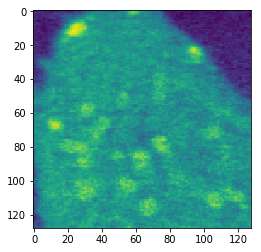

In [23]:
# Let's take a look at the raw image
plt.imshow(img_mrc.data[90,:,:])

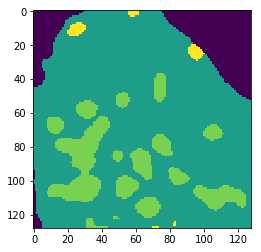

In [24]:
# And let's take a look at the segmentd image:
plt.imshow(img_labels_mrc.data[90,:,:])

In [25]:
# Now lets display the spectra
#
# If you display the whole spectrum, all you will see are the largest 1 or 2
# entries in the spectrum (probably at low frequencies).
# So instead of showing the whole spectrum, scale the Y axis so that you can
# see a certain fraction of them ("median_fraction", for example 85% of them).
img_spectrum_sorted = [f for f in img_spectrum]
img_spectrum_sorted.sort()
median_fraction = 0.85
median_fraction_i = int(floor(median_fraction*len(img_spectrum_sorted)))
ymax = img_spectrum_sorted[median_fraction_i]

(0, 15.680628038573468)

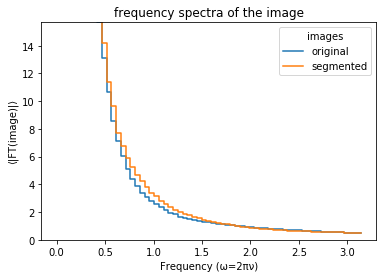

In [27]:
plt.step(frequencies, img_spectrum, where='mid', label='original')
plt.step(frequencies, img_labels_spectrum, where='mid',label='segmented')
plt.title('frequency spectra of the image')
plt.ylabel('⟨|FT(image)|⟩')
plt.xlabel('Frequency (ω=2πν)')
plt.legend(title='images')
plt.ylim(bottom=0, top=ymax)

(0, 2)

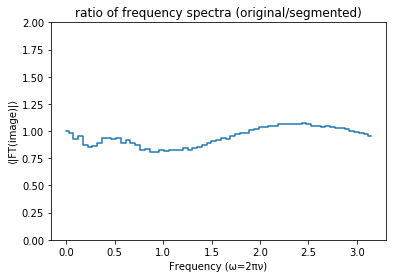

In [30]:
# For low frequencies at least, the two images have very similar 
# frequency spectra (as seen above).  The high frequencies are
# two weak to compare visually using the method above, but we
# can divide one spectra by the other.  If the spectra are similar,
# the result of division should hover near 1.0 (which it does):
plt.step(frequencies, img_spectrum/img_labels_spectrum, where='mid')
plt.title('ratio of frequency spectra (original/segmented)')
plt.ylabel('⟨|FT(image)|⟩')
plt.xlabel('Frequency (ω=2πν)')
plt.ylim(bottom=0, top=2)